### Описания полей

- client_id - идентификатор клиента


- education - уровень образования


- sex - пол заемщика


- age - возраст заемщика


- car - флаг наличия автомобиля


- car_type - флаг автомобиля иномарки


- decline_app_cnt - количество отказанных прошлых заявок


- good_work - флаг наличия “хорошей” работы


- bki_request_cnt - количество запросов в БКИ


- home_address - категоризатор домашнего адреса


- work_address - категоризатор рабочего адреса


- income - доход заемщика


- foreign_passport - наличие загранпаспорта


- sna - связь заемщика с клиентами банка


- first_time - давность наличия информации о заемщике


- score_bki - скоринговый балл по данным из БКИ


- region_rating - рейтинг региона


- app_date - дата подачи заявки

- default - флаг дефолта по кредиту

In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
print('набор данных для обучения \nshape=', train.shape)
print('набор данных для тестирования \nshape=', test.shape)

набор данных для обучения 
shape= (73799, 19)
набор данных для тестирования 
shape= (36349, 18)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
print(train.default.value_counts())
print('Соотношение количество значений 1 к количеству значений 0 в целевой переменной в тренировочной выборке:',
      int(train.default.value_counts()[1] / train.default.value_counts()[0] *100), '%')

0    64427
1     9372
Name: default, dtype: int64
Соотношение количество значений 1 к количеству значений 0 в целевой переменной в тренировочной выборке: 14 %


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [7]:
# Для корректной обработки данных объединим train и test в один датасет

train['is_test'] = 0 # помечаем train
test['is_test'] = 1 # помечаем test
#test['default'] = 1  # imaginary value for now

df = train.append(test, sort=False).reset_index(drop=True)
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,is_test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0


In [8]:
df.shape

(110148, 20)

## Заполним пропуски

In [9]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
is_test                 0
dtype: int64

In [10]:
# Пропуски содержатся только в признаке education, default наш целевой признак

df.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [11]:
# Пропуски признака education заполним модой

df.education[df.education.isna()] = df.education.mode()[0]

In [12]:
df.isna().sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
is_test                 0
dtype: int64

## Обработка временного признака

In [13]:
df.app_date = pd.to_datetime(df.app_date)
df.app_date.dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

In [14]:
df.app_date.dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

#### Интервал дат в выборке: январь-апрель 2014. Даты распределены в тренировочной и в тестовой выборках примерно одинаково.

In [15]:
# Создадим новый признак: день недели подачи заявки 

df['app_weekday'] = df.app_date.dt.weekday
df.app_weekday.value_counts()

1    18180
0    17858
2    17581
3    17421
4    16749
5    12202
6    10157
Name: app_weekday, dtype: int64

#### На выходные дни приходится значительно меньше заявок, чем на будни.

In [16]:
# преобразование даты в число

df.app_date = df.app_date.dt.strftime('%m%d').astype('int64')

In [17]:
# новый признак: количество заявок в данный день

apps_per_date = df.app_date.value_counts()

df['apps_per_day'] = df.app_date.map(apps_per_date)

### Разделим переменные на группы

In [18]:
# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные признаки
cat_cols = ['education', 'home_address', 'work_address',
        'sna', 'first_time','app_weekday']

# числовые признаки
num_cols = ['app_date', 'age', 'decline_app_cnt', 'score_bki',
        'bki_request_cnt', 'region_rating', 'income','apps_per_day']

## Обработка признаков

### Числовые признаки

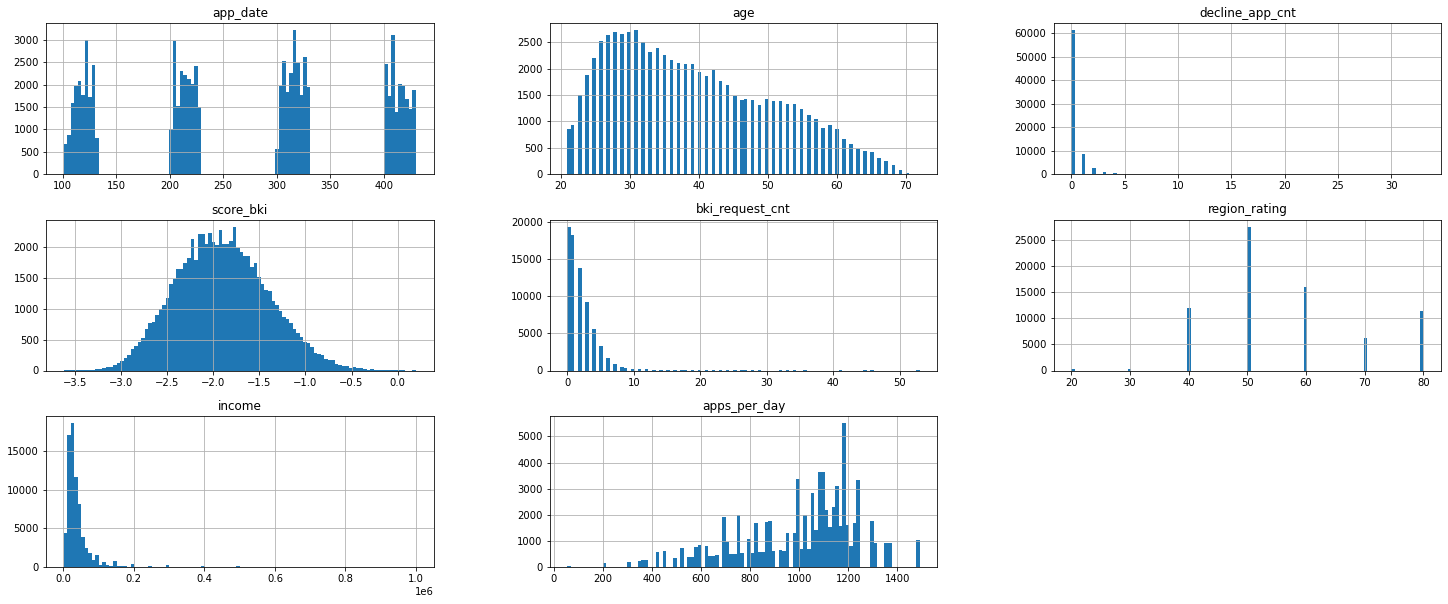

In [19]:
df[df.is_test == 0][num_cols].hist(figsize=(25,10),bins=100);

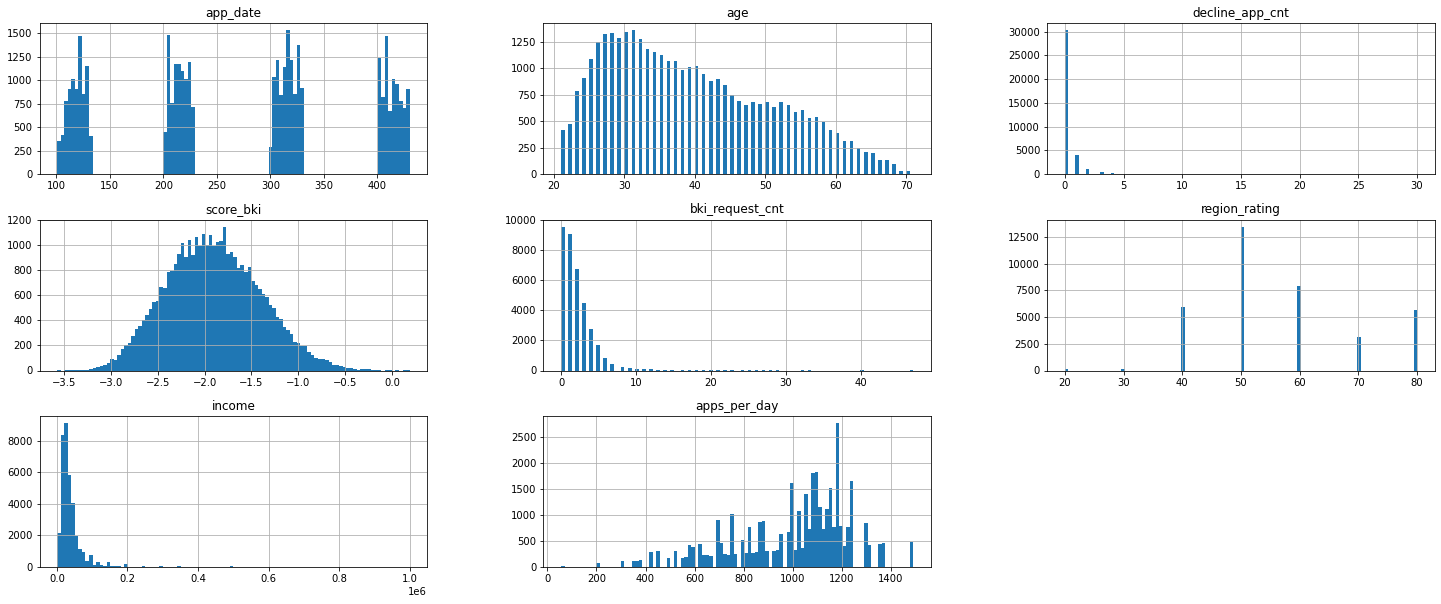

In [20]:
df[df.is_test == 1][num_cols].hist(figsize=(25,10),bins=100);

Распределение признаков в тренировочной и тестовой выборках одинаково.

array([[<AxesSubplot:title={'center':'app_date'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'decline_app_cnt'}>],
       [<AxesSubplot:title={'center':'score_bki'}>,
        <AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'region_rating'}>],
       [<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'apps_per_day'}>, <AxesSubplot:>]],
      dtype=object)

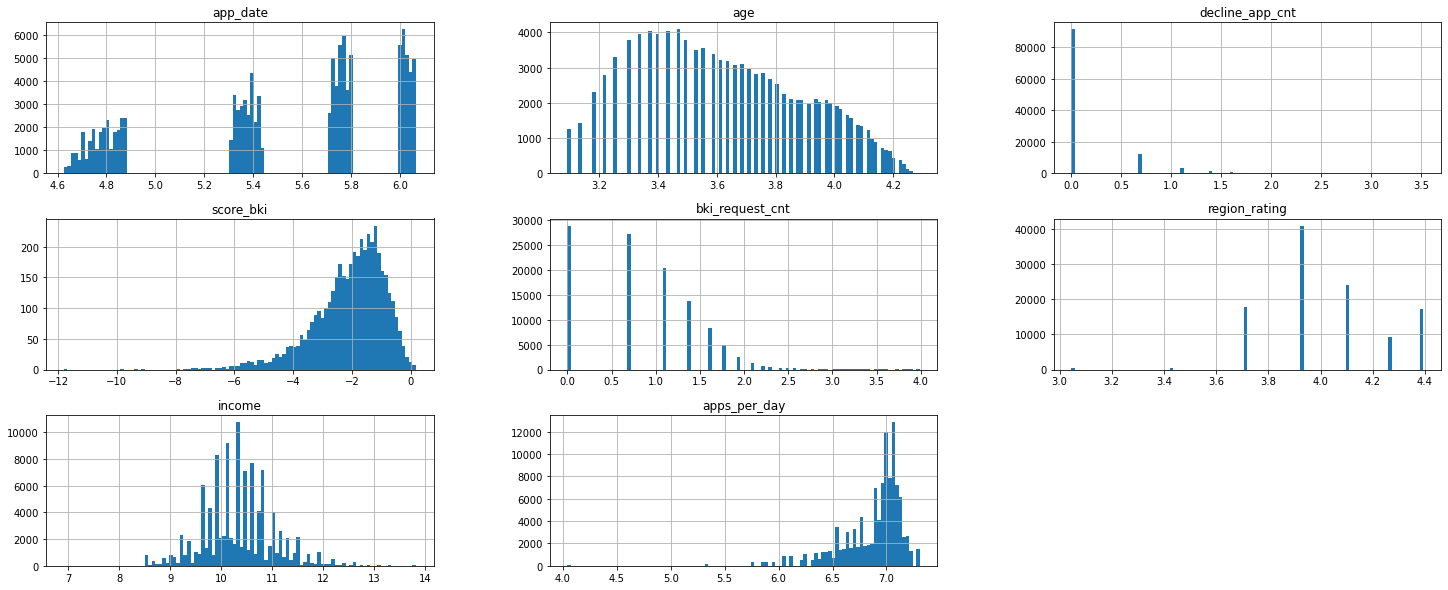

In [21]:
# Посмотрим на прологарифмируемые признаки для приближения к виду нормального распределения

(np.log(df[num_cols]+1)).hist(figsize=(25,10),bins=100)

Некоторые признаки после логарифмирования выглядят более приближенными к виду нормального распеределения.

In [22]:
# Прологорифмируем выбранные признаки

for i in ['age', 'bki_request_cnt', 'decline_app_cnt', 'income']:
    df[i] = np.log(df[i]+1)

<AxesSubplot:>

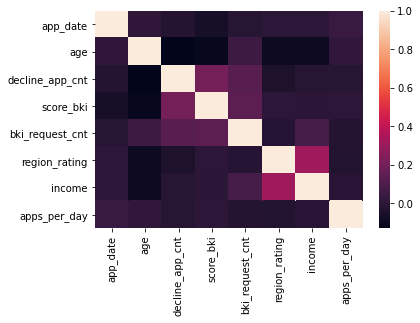

In [23]:
sns.heatmap(df[num_cols].corr())

In [24]:
# # стандартизация:

sscaler = StandardScaler()
df[num_cols] = pd.DataFrame(sscaler.fit_transform(df[num_cols]),columns=num_cols)

<AxesSubplot:>

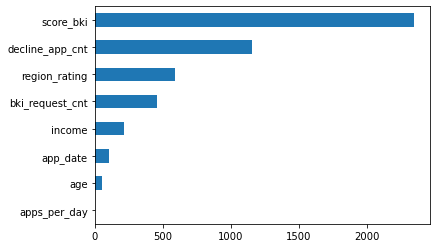

In [25]:
# оценка значимости числовых признаков:

imp_num = pd.Series(f_classif(df[df.is_test==0][num_cols], df[df.is_test==0]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из числовых признаков наиболее значимым является score_bki

## Бинарные признаки

In [26]:
# преобразуем в числа

label_encoder = LabelEncoder()

for i in bin_cols:
    df[i] = label_encoder.fit_transform(df[i])  

array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'car'}>],
       [<AxesSubplot:title={'center':'car_type'}>,
        <AxesSubplot:title={'center':'good_work'}>],
       [<AxesSubplot:title={'center':'foreign_passport'}>,
        <AxesSubplot:>]], dtype=object)

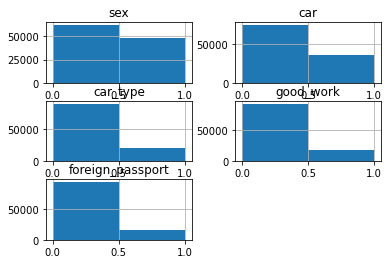

In [27]:
df[bin_cols].hist(bins=2)

In [28]:
df[bin_cols].describe()

,sex,car,car_type,good_work,foreign_passport
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,0.438610,0.325544,0.190725,0.165514,0.149136
std,0.496219,0.468580,0.392875,0.371645,0.356224
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

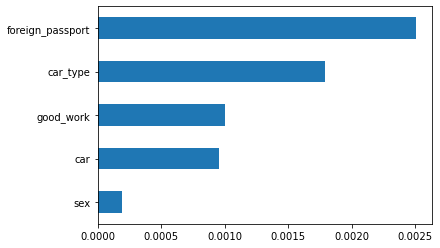

In [29]:
# оценка значимости бинарных признаков:

imp_bin = pd.Series(mutual_info_classif(df[df.is_test == 0][bin_cols], df[df.is_test == 0]['default'],
                                        discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

Из бинарных признаков наиболее значимыми являются foreign_passport и car_type.

## Категориальные признаки

In [30]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   education     110148 non-null  object
 1   home_address  110148 non-null  int64 
 2   work_address  110148 non-null  int64 
 3   sna           110148 non-null  int64 
 4   first_time    110148 non-null  int64 
 5   app_weekday   110148 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 5.0+ MB


In [31]:
# mutual_info_classif сначала требует, чтобы категориальные значения были сопоставлены с целочисленными значениями,
# и нам в этом помешал 'education'
# Преобразуйте этот признак в численный формат

df['education'] = label_encoder.fit_transform(df['education'])

<AxesSubplot:>

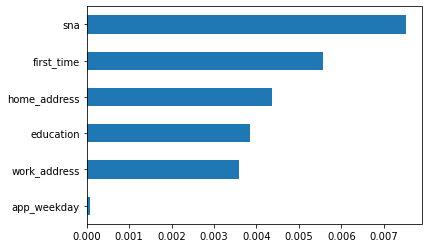

In [32]:
# определите важность признаков.

imp_cat = pd.Series(mutual_info_classif(df[df.is_test == 0][cat_cols], df[df.is_test == 0]['default'],
                                        discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [33]:
# на основе категориальных признаков сознадим dummy переменные

df_dummies = pd.get_dummies(df[cat_cols].astype('object'))

In [34]:
dummy_cols = df_dummies.columns
df = pd.concat([df, df_dummies], axis=1)

In [35]:
# т.к. категориальные признаки заменены избавися от них

df.drop(columns=cat_cols, inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 42 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  float64
 2   sex               110148 non-null  int32  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int32  
 5   car_type          110148 non-null  int32  
 6   decline_app_cnt   110148 non-null  float64
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  float64
 10  region_rating     110148 non-null  float64
 11  income            110148 non-null  float64
 12  foreign_passport  110148 non-null  int32  
 13  default           73799 non-null   float64
 14  is_test           110148 non-null  int64  
 15  apps_per_day      110148 non-null  float64
 16  education_0       11

In [37]:
cat_cols=dummy_cols

## Модель

In [38]:
X = df[df.is_test == 0].drop(columns=['client_id','default'])
Y = df[df.is_test == 0]['default']

x_pred = df[df.is_test == 1].drop(columns=['client_id','default'])

# Разделим выборку на train и test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

model = LogisticRegression(random_state=42, max_iter=10000)
model.fit(X_train, Y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

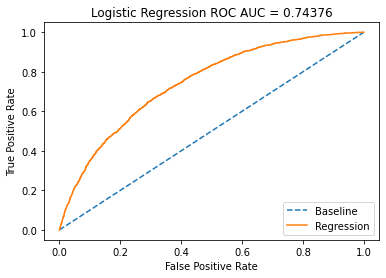

In [39]:
fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [53]:
y_pred = model.predict(X_test)

In [52]:
pd.Series(y_pred).value_counts()

0.0    14657
1.0      103
dtype: int64

In [42]:
pd.Series(probs).describe()

count    14760.000000
mean         0.127240
std          0.099269
min          0.004625
25%          0.056245
50%          0.098319
75%          0.168336
max          0.815053
dtype: float64

<AxesSubplot:>

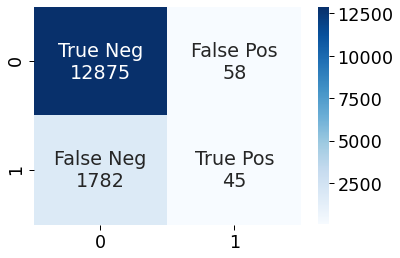

In [44]:
# Визуализация confusion matrix:

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Blues')

Mожно сделать вывод, что почти во всех случаях, когда клиент не способен выплатить кредит - модель все равно его выдаст. Данное решение приведет к падению доходов банка. Попробуем найти оптимальные гиперпараметры.

In [45]:
# Добавим типы регуляризации
penalty = ['l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 2, 20)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
model = LogisticRegression(random_state=42, max_iter=10000)
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, Y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


In [46]:
p = best_model.best_estimator_.get_params()['penalty']
c = best_model.best_estimator_.get_params()['C']

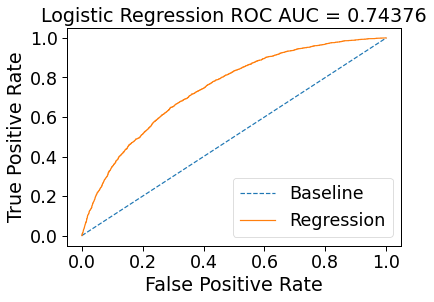

In [50]:
model = LogisticRegression(penalty=p,C=c, random_state=42, max_iter=10000).fit(X_train, Y_train)

probs = model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Регуляризация не показала видимого улучшения качества модели.

In [48]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.8753
f1_score: 0.0466
recall_score: 0.0246
MSE: 0.1247


## Результат

In [54]:
y_pred = model.predict(x_pred)

In [55]:
y_pred_proba = model.predict_proba(x_pred)

In [56]:
x_pred

,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,first_time_2,first_time_3,first_time_4,app_weekday_0,app_weekday_1,app_weekday_2,app_weekday_3,app_weekday_4,app_weekday_5,app_weekday_6
73799,0.487897,1,-0.888776,1,1,-0.418815,0,-0.735587,0.770563,-0.516704,...,0,0,1,0,0,0,0,0,1,0
73800,-1.351115,0,0.120447,0,0,4.539989,0,0.800039,0.333797,-0.516704,...,0,1,0,0,0,0,0,1,0,0
73801,0.497185,1,0.972731,1,1,-0.418815,0,0.426908,-0.281790,-0.516704,...,0,1,0,0,0,0,0,0,0,1
73802,-0.617368,1,1.362924,0,0,-0.418815,0,-0.940432,-0.281790,-1.282058,...,0,1,0,1,0,0,0,0,0,0
73803,-0.608080,0,0.031629,0,0,-0.418815,0,-1.167347,-1.334144,1.779355,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0.571488,0,-0.059496,0,0,1.499512,0,0.319505,0.770563,-0.516704,...,0,0,0,1,0,0,0,0,0,0
110144,1.444554,0,1.823666,1,1,-0.418815,0,-0.779436,0.770563,0.248649,...,0,0,1,0,0,0,0,1,0,0
110145,0.562200,1,-0.662367,0,0,2.621662,0,1.929901,-0.281790,-0.516704,...,1,0,0,0,0,0,0,0,0,1
110146,-1.509010,0,-1.130811,0,0,1.499512,0,1.325890,0.333797,1.779355,...,0,0,0,0,1,0,0,0,0,0


In [57]:
len(y_pred)

36349

In [59]:
submission_proba = test.client_id.to_frame()
submission_proba['default'] = y_pred_proba[:,1]
submission_proba

,client_id,default
0,74835,0.040324
1,17527,0.349213
2,75683,0.061361
3,26883,0.094024
4,28862,0.027068
...,...,...
36344,83775,0.345574
36345,106254,0.016055
36346,81852,0.340140
36347,1971,0.186823


In [60]:
submission_proba.to_csv('submission1.csv', index = False)